## 偏差和方差

- 偏差：预测值与真实值的差距（表示算法本身的拟合能力）
- 方差：预测值的变化范围（表示数据扰动造成的影响）

---

高偏差：引入更多相关特征、采用多项式特征、减小$\lambda$

高方差：采用更多样本数据、减少特征数量（除去非主要特征）、增加$\lambda$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

In [2]:
data = loadmat("exp5data1.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [3]:
X_train, y_train = data["X"], data["y"]
X_train.shape, y_train.shape

((12, 1), (12, 1))

In [4]:
X_val, y_val = data["Xval"], data["yval"]
X_val.shape, y_val.shape

((21, 1), (21, 1))

In [5]:
X_test, y_test = data["Xtest"], data["ytest"]
X_test.shape, y_test.shape

((21, 1), (21, 1))

In [6]:
X_train = np.insert(X_train, 0, 1, axis=1)
X_val = np.insert(X_val, 0, 1, axis=1)
X_test = np.insert(X_test, 0, 1, axis=1)
X_train.shape

(12, 2)

In [7]:
X_train

array([[  1.        , -15.93675813],
       [  1.        , -29.15297922],
       [  1.        ,  36.18954863],
       [  1.        ,  37.49218733],
       [  1.        , -48.05882945],
       [  1.        ,  -8.94145794],
       [  1.        ,  15.30779289],
       [  1.        , -34.70626581],
       [  1.        ,   1.38915437],
       [  1.        , -44.38375985],
       [  1.        ,   7.01350208],
       [  1.        ,  22.76274892]])

In [8]:
def plotData():
    fig, ax = plt.subplots()
    ax.scatter(X_train[:, 1], y_train)
    ax.set(xlabel="change in water level(x)",
          ylabel="water flowing out on the dam(y)")

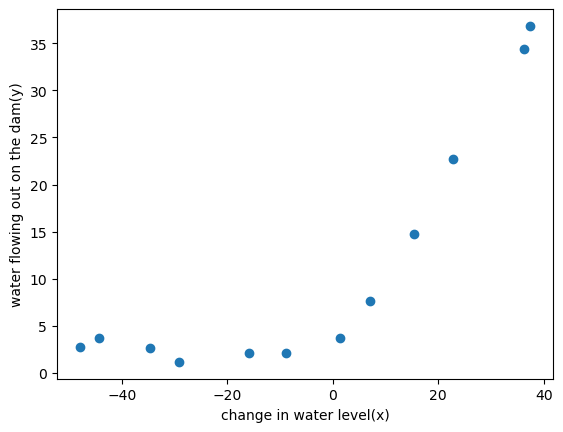

In [9]:
plotData()

## 正则化损失函数

In [10]:
def regCost(theta, X, y, lamda):
    cost = np.sum(np.power(X@theta - y.flatten(), 2))
    reg = theta[1:]@theta[1:] * lamda

    return (cost+reg) / (2 * (len(X)))

In [11]:
theta = np.ones(X_train.shape[1])
lamda = 1
regCost(theta, X_train, y_train, lamda)

303.9931922202643

## 正则化梯度下降函数

In [12]:
def regGradient(theta, X, y, lamda):
    grad = (X@theta - y.flatten())@X
    reg = lamda * theta
    reg[0] = 0
    return (grad+reg) / len(X)

In [13]:
regGradient(theta, X_train, y_train, lamda)

array([-15.30301567, 598.25074417])

In [14]:
def trainModel(X, y, lamda):
    theta = np.ones(X.shape[1])
    res = minimize(fun=regCost,
                  x0=theta,
                  args=(X,y,lamda),
                  method="TNC",
                  jac=regGradient)

    return res.x

In [15]:
theta_final = trainModel(X_train, y_train, lamda=0)

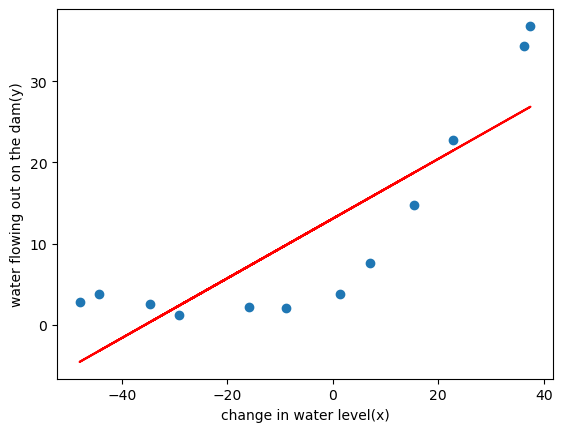

In [16]:
plotData()
plt.plot(X_train[:,1], X_train@theta_final, c="r")

---
训练样本从1开始递增进行训练，比较训练集和验证集上的损失函数变化情况：

In [17]:
def plotLearningCurve(X_train, y_train, X_val, y_val, lamda):
    train_cost = []
    val_cost = []
    x = range(1, len(X_train)+1)

    for i in x:
        res = trainModel(X_train[:i, :], y_train[:i, :], lamda)
        train_cost_i = regCost(res, X_train[:i, :], y_train[:i, :], lamda)
        val_cost_i = regCost(res, X_val, y_val, lamda)
        train_cost.append(train_cost_i)
        val_cost.append(val_cost_i)

    plt.plot(x, train_cost, label="train_cost")
    plt.plot(x, val_cost, label="val cost")
    plt.legend()
    plt.xlabel("number of training examples")
    plt.ylabel("error")
    plt.show()

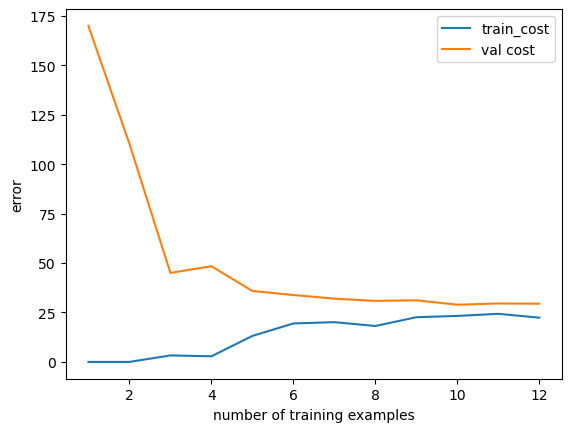

In [18]:
plotLearningCurve(X_train, y_train, X_val, y_val, lamda=0)

## 构造多项式特征、进行多项式回归 → 降低偏差

In [19]:
def polyFeature(X, power):
    for i in range(2, power+1):
        X = np.insert(X, X.shape[1], np.power(X[:, 1], i), axis=1)
    return X

In [20]:
# 求平均值和方差
def getMeansStds(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)

    return means, stds

In [21]:
# 归一化
def featureNormalize(X, means, stds):
    X[:,1:] = (X[:, 1:] - means[1:]) / stds[1:]

    return X

In [22]:
power = 6

In [23]:
X_train_poly = polyFeature(X_train, power)
X_val_poly = polyFeature(X_val, power)
X_test_poly = polyFeature(X_test, power)

In [24]:
train_means, train_stds = getMeansStds(X_train_poly)

In [25]:
# 特征归一化
X_train_norm = featureNormalize(X_train_poly, train_means, train_stds)
X_val_norm = featureNormalize(X_val_poly, train_means, train_stds)
X_test_norm = featureNormalize(X_test_poly, train_means, train_stds)

In [26]:
theta_fit = trainModel(X_train_norm, y_train, lamda=0)

In [27]:
def plotPolyFit():
    plotData()

    x = np.linspace(-60, 60, 100)
    xx = x.reshape(100, 1)
    xx = np.insert(xx, 0, 1, axis=1)
    xx = polyFeature(xx, power)
    xx = featureNormalize(xx, train_means, train_stds)

    plt.plot(x, xx@theta_fit, "r--")

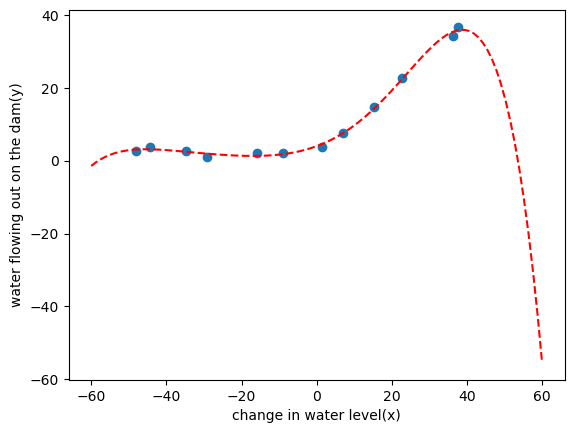

In [28]:
plotPolyFit()

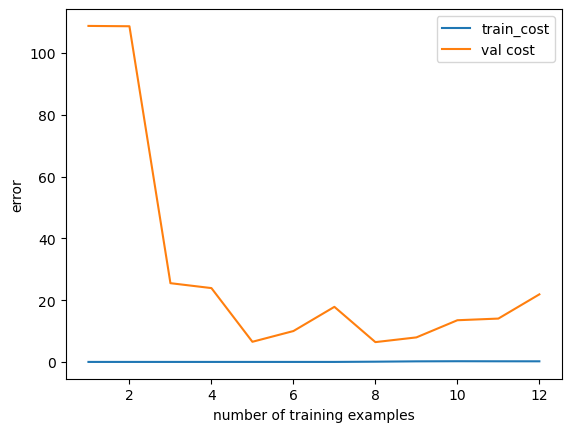

In [29]:
plotLearningCurve(X_train_norm, y_train, X_val_norm, y_val, lamda=0)

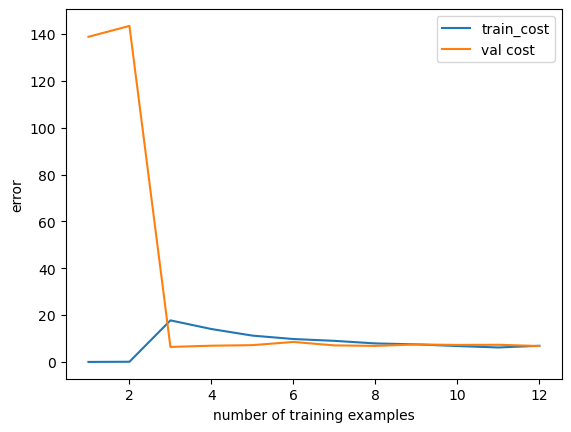

In [30]:
plotLearningCurve(X_train_norm, y_train, X_val_norm, y_val, lamda=1)

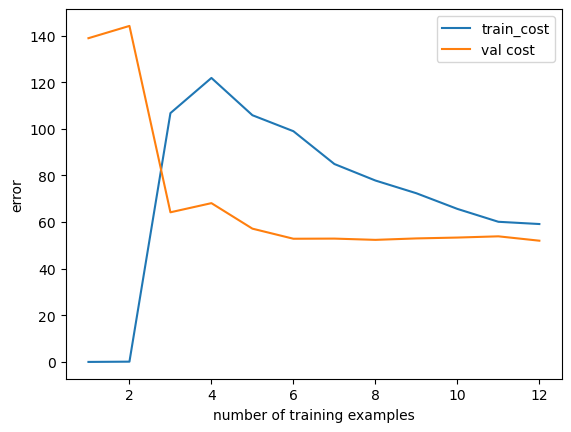

In [31]:
plotLearningCurve(X_train_norm, y_train, X_val_norm, y_val, lamda=50)

In [32]:
lamdas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
training_costs = []
val_costs = []

for lamda in lamdas:
    res = trainModel(X_train_norm, y_train, lamda)  # 训练时正则化

    training_cost = regCost(res, X_train_norm, y_train, lamda=0)
    val_cost = regCost(res, X_val_norm, y_val, lamda=0)

    training_costs.append(training_cost)
    val_costs.append(val_cost)

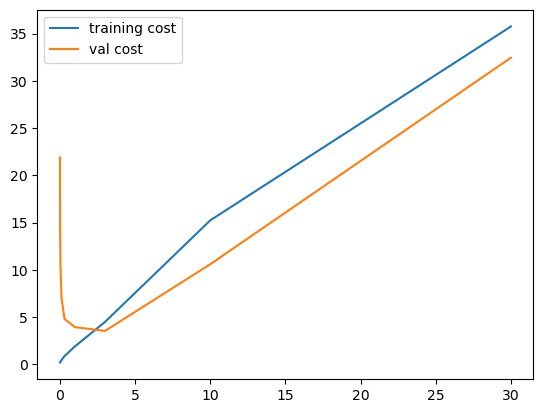

In [33]:
plt.plot(lamdas,training_costs,label='training cost')
plt.plot(lamdas,val_costs,label='val cost')
plt.legend()

plt.show()

In [34]:
lamdas[np.argmin(val_costs)]

3

In [35]:
res = trainModel(X_train_norm, y_train, lamda=3)
test_cost = regCost(res, X_test_norm, y_test, lamda=0)
test_cost

4.397616217271634